# Association between spectra factors and variables of interest

## Libraries and background data

In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import glob
import sys
#import scvi
import gc
import re
import cytopus as cp
import Spectra
import gseapy as gp
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")

/tmp/ipykernel_169123/2890477736.py:1: DtypeWarning: Columns (4,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,130,131,132,133,134,135,136,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,185,187,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")


In [4]:
inscore = pd.read_csv("misc/inscore_FID.csv")

In [3]:
site_collect = sample_info_raw[['ID:topmed',
                                'ID:field',
                                'Subject_Information:Ethnicity::str',
                                'Collection_Information:Latitude::num::deg',
                                'Collection_Information:Longitude::num::deg',
                                'Collection_Information:Site::str',
                                'Collection_Information:Date::date',
                                'Categorization:Lifestyle:Subsistence_Practice::str',
                                'Categorization:Lifestyle:Subsistence_Practice:Notes::str']]

site_collect = site_collect.rename(columns={'ID:topmed': 'TID',
                                            'ID:field': 'FID',
                                            'Subject_Information:Ethnicity::str': 'Ethnicity',
                                            'Collection_Information:Latitude::num::deg': 'latitude',
                                            'Collection_Information:Longitude::num::deg': 'longitude',
                                            'Collection_Information:Site::str': 'site',
                                            'Collection_Information:Date::date': 'date',
                                            'Categorization:Lifestyle:Subsistence_Practice::str': 'subsistence'})

## Functions

In [5]:
def harmonize_str(x):

    return(x.replace(" ", "_").replace("+", "pos").replace("-", "neg").replace("/", "_"))

In [6]:
def spectra_lmm_test(adata, ctype_fracs, focal_pop):

    scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], index=adata.obs.index, columns=adata.uns['SPECTRA_overlap'].index)
    
    scores_means = scores_df.merge(adata.obs[['FID','COND','cytopus_names']], left_index=True, right_index=True) \
    .groupby(['FID','COND','cytopus_names']).mean().reset_index()\
    .merge(adata.obs[['FID','AGE','SEX','Ethnicity','Sabga_June']].drop_duplicates())

    scores_means[focal_pop] = pd.Categorical([focal_pop if i==focal_pop else 'Other' for i in scores_means['Ethnicity']], 
                                             categories=['Other',focal_pop])

    # Drop Progenitor, DNT, and MAIT due to low cell numbers and NaN
    scores_means = scores_means[~scores_means['cytopus_names'].isin(['Progenitor','DNT','MAIT'])]

    factors = adata.uns['SPECTRA_overlap'].index

    # LMM with individual as random effect
    results_list = []
    results_ns_list = []
    
    for factor in factors:
        
        scores_factor = scores_means[['cytopus_names','FID','AGE','SEX','COND',focal_pop,'Sabga_June',factor]]
        ctype_scores = scores_factor.groupby('cytopus_names').sum(numeric_only=True).reset_index()
        ctype_keep = ctype_scores[~(ctype_scores[factor]==0)]['cytopus_names'].astype(str)
    
        for ctype in ctype_keep:

            ctype_cols = list(ctype_fracs[ctype].columns)[:-1]
            ctype_cols_Q = [ "Q(\"{}\")".format(i) for i in ctype_cols ]
            ctype_formula = " + ".join(ctype_cols_Q)
            
            scores_sub = scores_factor[scores_factor['cytopus_names']==ctype]
            scores_sub = scores_sub.merge(ctype_fracs[ctype].reset_index())
            scores_sub[factor] = (scores_sub[factor] - np.mean(scores_sub[factor])) / np.std(scores_sub[factor])
            formula = "Q(\"" + factor + "\")" + " ~ AGE + SEX + COND*{} + Sabga_June + {}".format(focal_pop, ctype_formula)
            return({'formula': formula, 'scores_sub': scores_sub})

In [7]:
def spectra_lmm(adata, ctype_fracs, focal_pop):

    scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], index=adata.obs.index, columns=adata.uns['SPECTRA_overlap'].index)
    
    scores_means = scores_df.merge(adata.obs[['FID','COND','cytopus_names']], left_index=True, right_index=True) \
    .groupby(['FID','COND','cytopus_names']).mean().reset_index()\
    .merge(adata.obs[['FID','AGE','SEX','Ethnicity','Sabga_June']].drop_duplicates())

    scores_means[focal_pop] = pd.Categorical([focal_pop if i==focal_pop else 'Other' for i in scores_means['Ethnicity']], 
                                             categories=['Other',focal_pop])

    # Drop Progenitor, DNT, and MAIT due to low cell numbers and NaN
    scores_means = scores_means[~scores_means['cytopus_names'].isin(['Progenitor','DNT','MAIT'])]

    factors = adata.uns['SPECTRA_overlap'].index

    # LMM with individual as random effect
    results_list = []
    results_ns_list = []
    
    for factor in factors:
        
        scores_factor = scores_means[['cytopus_names','FID','AGE','SEX','COND',focal_pop,'Sabga_June',factor]]
        ctype_scores = scores_factor.groupby('cytopus_names').sum(numeric_only=True).reset_index()
        ctype_keep = ctype_scores[~(ctype_scores[factor]==0)]['cytopus_names'].astype(str)
    
        for ctype in ctype_keep:

            ctype_cols = list(ctype_fracs[ctype].columns)[:-1]
            ctype_cols_Q = [ "Q(\"{}\")".format(i) for i in ctype_cols ]
            ctype_formula = " + ".join([" "] + ctype_cols_Q)

            
            if len(ctype_cols)==0:
                ctype_formula = ""
            
            scores_sub = scores_factor[scores_factor['cytopus_names']==ctype]
            scores_sub = scores_sub.merge(ctype_fracs[ctype][ctype_cols].reset_index())
            scores_sub[factor] = (scores_sub[factor] - np.mean(scores_sub[factor])) / np.std(scores_sub[factor])
            if len(ctype_cols)>0:
                scores_sub[ctype_cols] = (scores_sub[ctype_cols] - np.mean(scores_sub[ctype_cols])) / np.std(scores_sub[ctype_cols])
            formula = "Q(\"" + factor + "\")" + " ~ AGE + SEX + COND*{} + Sabga_June{}".format(focal_pop, ctype_formula)
            md = smf.mixedlm(formula, scores_sub, groups=scores_sub['FID'])
            mdf = md.fit()
    
            results_df = mdf.params.to_frame('param')\
                .merge(mdf.pvalues.to_frame('pvalue'), left_index=True, right_index=True)\
                .reset_index(names="var")
            results_df['ctype'] = ctype
            results_df['factor'] = factor

            results_list.append(results_df)

            
            scores_sub = scores_sub[scores_sub['Sabga_June']==False]
            formula = "Q(\"" + factor + "\")" + " ~ AGE + SEX + COND*{}{}".format(focal_pop, ctype_formula)

            md = smf.mixedlm(formula, scores_sub, groups=scores_sub['FID'])
            mdf = md.fit()
    
            results_df = mdf.params.to_frame('param')\
                .merge(mdf.pvalues.to_frame('pvalue'), left_index=True, right_index=True)\
                .reset_index(names="var")
            results_df['ctype'] = ctype
            results_df['factor'] = factor
            
            results_ns_list.append(results_df)

    return({'Sabga_June': pd.concat(results_list),
            'no_Sabga_June': pd.concat(results_ns_list)})
            

In [8]:
def get_GO_terms(markers, bground):

    enr = gp.enrichr(gene_list=markers,
                     gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2025','Reactome_Pathways_2024'],
                     background=bground,
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None, # don't write to disk
                    )

    return(enr.results)

In [9]:
def get_prerank_terms(markers):

    enr = gp.prerank(rnk=markers,
                     gene_sets=['GO_Biological_Process_2025'],
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     seed=6,
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None, # don't write to disk
                    )

    return(enr)

In [10]:
def grouped_obs_sum(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.sum(axis=0, dtype=np.float64))
    return out

## Main

In [9]:
spectra_file = '../../test/test123/write/qc_020725.spectra_out.4k.h5ad'

In [10]:
adata = sc.read_h5ad(spectra_file, backed='r')

In [11]:
scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], index=adata.obs.index, columns=adata.uns['SPECTRA_overlap'].index)
adata.obs[adata.uns['SPECTRA_overlap'].index] = scores_df

In [12]:
ct_map = {'B cells': 'B',
          'CD4+ T cells': 'CD4T',
          'DN T cells': 'DNT',
          'MAIT cells': 'MAIT',
          'Myeloid cells': 'Myeloid',
          'NK cells': 'NK',
          'Progenitor cells': 'Progenitor',
          'TRAV1-2- CD8+ T cells': 'CD8T',
          'gd T cells': 'gdT'}

In [13]:
# clean up cell types
ctypes = pd.read_csv("../../sample_info/celltype_map.022125.csv")
ctype_dict = dict(zip(ctypes['Tier_1'] + ":" + ctypes['Tier_3'], 
                      ctypes['Tier_1'].apply(lambda x: ct_map[x]) + "," + ctypes['Tier_2'].apply(lambda x: harmonize_str(str(x)))))
adata.obs['ct2'] = adata.obs['FCluster_names'].apply(lambda x: ctype_dict[x])

In [14]:
adata_umap = sc.read_h5ad("../../test/test123/write/qc_020725_wctypes.harmony.umap.h5ad", backed='r')
adata.obsm['X_umap'] = adata_umap[adata.obs_names].obsm['X_umap']

### Get cell type fractions for each cell type

In [17]:
ctypes = np.unique(adata.obs['cytopus_names'])

In [18]:
ctype_frac_dict = {}
for ctype in ctypes:

    ctype_fracs = adata[adata.obs['cytopus_names']==ctype].obs.groupby(['FID','COND'])['ct2'].value_counts(normalize=True) \
        .to_frame().rename(columns={'ct2': 'frac'}).reset_index().pivot(index=['FID','COND'], columns='ct2', values='frac')
    
    ctype_fracs[ctype_fracs.isna()] = 0

    col_sums = ctype_fracs.sum()
    sorted_sums = col_sums.sort_values(ascending=False)
    
    ctype_frac_dict[ctype] = ctype_fracs[sorted_sums.index]

### Continue on

In [17]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00"]

In [18]:
adata.obs[['site','date']] = adata.obs[['FID']].reset_index().merge(site_collect[['FID','site','date']]).set_index('index')[['site','date']]
adata.obs['Sabga_June'] = pd.Series((adata.obs['site']=="Sabga") & 
                                    (adata.obs['date'].isin(contam_dates)), dtype='category')

In [19]:
pops=['Tikari','Fulani','CHG']

In [ ]:
lmm_dict = {}
for pop in pops:

    lmm_dict[pop] = spectra_lmm(adata, ctype_frac_dict)

In [30]:
factors = adata.uns['SPECTRA_overlap'].index

In [18]:
adata

AnnData object with n_obs × n_vars = 2416314 × 36601 backed at '../../test/test123/write/qc_020725.spectra_out.4k.h5ad'
    obs: 'donor_id', 'library', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'doublet_score', 'predicted_doublet', 'FID', 'LID', 'TID', 'COHORT', 'COND', 'SEX', 'AGE', 'POP', 'Ethnicity', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'cytopus_names', '0-X-global-X-0', '1-X-global-X-1', '2-X-global-X-2', '3-X-B-X-3', '4-X-B-X-4', '5-X-B-X-5', '6-X-B-X-6', '7-X-B-X-7', '8-X-CD4-T-X-8', '9-X-CD4-T-X-9', '10-X-CD4-T-X-10', '11-X-CD4-T-X-11', '12-X-CD4-T-X-12', '13-X-CD4-T-X-13', '14-X-CD4-T-X-14', '15-X-CD4-T-X-15', '16-X-CD8-T-X-16', '17-X-CD8-T-X-17', '18-X-CD8-T-X-18', '19-X-CD8-T-X-19', '20-X-CD8-T-X-20', '21-X-DNT-X-21', '22-X-M-X-M_IL17A_response', '23-X-M-X-23', '24-X-M-X-M_IL17A_response', '25-X-M-X-25', '26-X-M-X-DC_antigen-crosspresentation', '27-X-M-X-27', '28-X-M-X-DC_

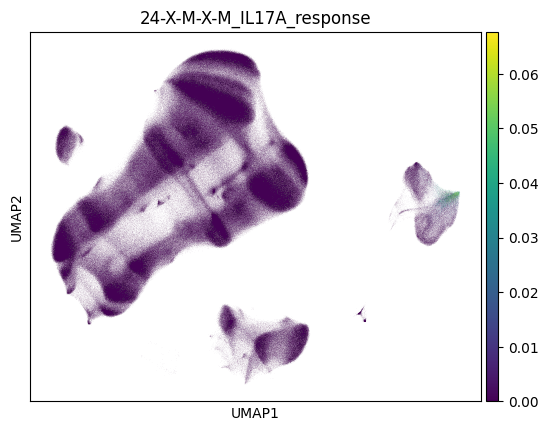

In [20]:
sc.pl.umap(adata, color="24-X-M-X-M_IL17A_response")

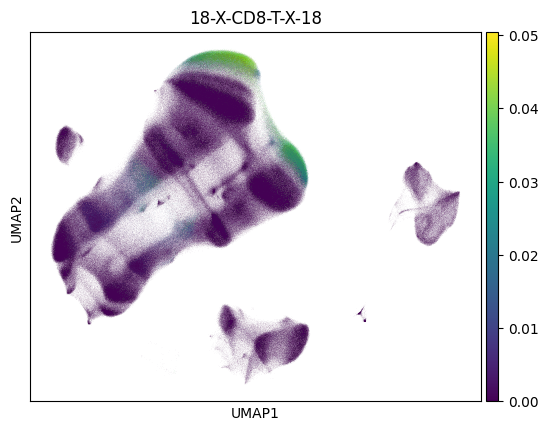

In [39]:
sc.pl.umap(adata, color="18-X-CD8-T-X-18")

In [54]:
lmm_dfs = []
for factor in factors:
    lmm_dfs.append(lmm_dict['Fulani']['Sabga_June'][lmm_dict['Fulani']['Sabga_June']['factor']==factor])

In [55]:
lmm_df = pd.concat(lmm_dfs)

<Axes: xlabel='ctype-factor', ylabel='var'>

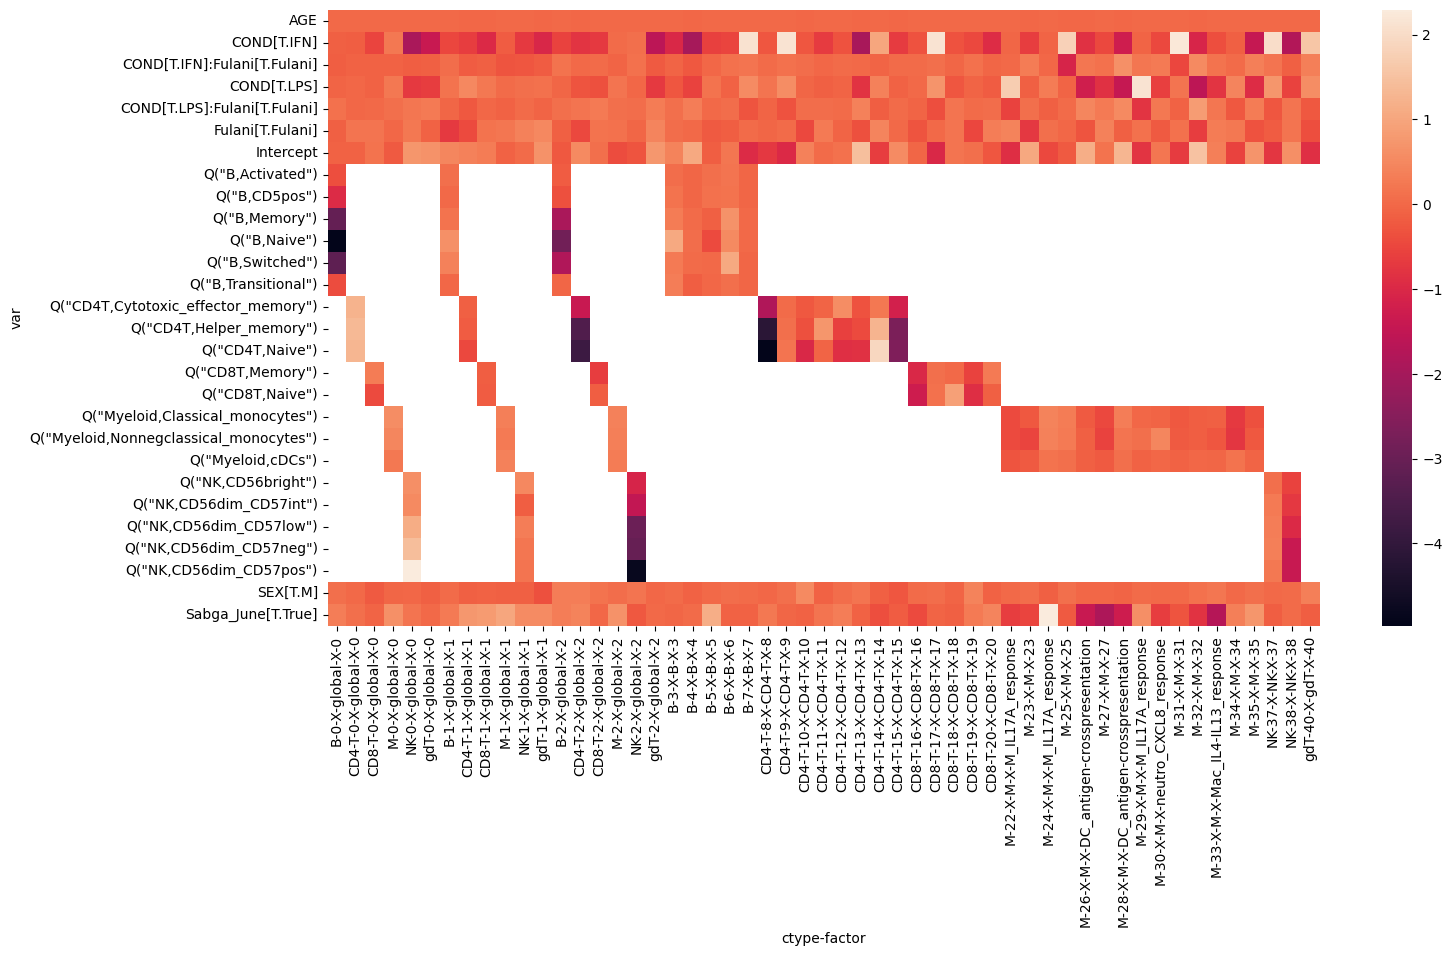

In [57]:
fig, ax = plt.subplots(figsize=(16,8)) 
sns.heatmap(lmm_df.pivot(index='var', columns=['ctype','factor'], values='param').drop('Group Var', axis=0))

In [43]:
fig, ax = plt.subplots(figsize=(12,6)) 
sns.heatmap(lmm_df.pivot(index='var', columns=['ctype','factor'], values='param').drop('Group Var', axis=0))

,var,param,pvalue,ctype,factor
0,Intercept,-0.456156,2.852880e-02,B,0-X-global-X-0
1,SEX[T.M],0.064563,6.404596e-01,B,0-X-global-X-0
2,COND[T.IFN],-0.201683,1.663080e-02,B,0-X-global-X-0
3,COND[T.LPS],-0.033978,6.674581e-01,B,0-X-global-X-0
4,CHG[T.CHG],0.523483,8.419312e-03,B,0-X-global-X-0
...,...,...,...,...,...
5,Sabga_June[T.True],-0.317022,3.335875e-03,gdT,40-X-gdT-X-40
6,COND[T.IFN]:CHG[T.CHG],-0.478036,8.934929e-05,gdT,40-X-gdT-X-40
7,COND[T.LPS]:CHG[T.CHG],-0.188151,1.230683e-01,gdT,40-X-gdT-X-40
8,AGE,0.008789,2.062096e-04,gdT,40-X-gdT-X-40


In [ ]:
lmm_dict['CHG']['Sabga_June'][lmm_dict['CHG']['Sabga_June']['factor']=="29-X-M-X-M_IL17A_response"].sort_values('pvalue').head(15)

In [ ]:
lmm_dict['CHG']['no_Sabga_June'][lmm_dict['CHG']['no_Sabga_June']['var']=="CHG[T.CHG]"].sort_values('pvalue').head()

In [ ]:
lmm_dict['Fulani']['no_Sabga_June'][lmm_dict['Fulani']['no_Sabga_June']['var']=="COND[T.IFN]:Fulani[T.Fulani]"].sort_values('pvalue').head()

In [ ]:
lmm_dict['Fulani']['no_Sabga_June'][lmm_dict['Fulani']['no_Sabga_June']['var']=="COND[T.LPS]:Fulani[T.Fulani]"].sort_values('pvalue').head()

In [ ]:
lmm_dict['Tikari']['no_Sabga_June'][lmm_dict['Tikari']['no_Sabga_June']['var']=='Q("NK,CD56dim_CD57low")'].sort_values('pvalue').head()

In [ ]:
np.unique(lmm_dict['Tikari']['no_Sabga_June']['var'])

In [ ]:
lmm_dict['Tikari']['no_Sabga_June'][lmm_dict['Tikari']['no_Sabga_June']['var']=="Tikari[T.Tikari]"].sort_values('pvalue').head()

In [ ]:
adata.uns['SPECTRA_markers'][29]

In [ ]:
adata.uns['SPECTRA_markers'][29]

In [ ]:
markers = list(adata.var_names[adata.var['spectra_vocab']][np.argsort(-adata.uns['SPECTRA_factors'][2,:])][0:100])
bground = markers_all
enr_results = get_GO_terms(markers, bground)

In [ ]:
enr_results[enr_results['Gene_set']=="GO_Biological_Process_2025"].sort_values('Adjusted P-value').head(50)

In [ ]:
scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], 
                           index=adata.obs.index, 
                           columns=adata.uns['SPECTRA_overlap'].index)

scores_means = scores_df.merge(adata.obs[['FID','COND','cytopus_names']], left_index=True, right_index=True) \
.groupby(['FID','COND','cytopus_names']).mean().reset_index()\
.merge(adata.obs[['FID','AGE','SEX','Ethnicity','Sabga_June']].drop_duplicates())

In [ ]:
for ctype in ['CD8-T']:
    y = scores_means[adata.uns['SPECTRA_overlap'].index[29]]
    sc_means_ctype = scores_means[scores_means['cytopus_names']==ctype]
    sc_means_ctype = sc_means_ctype[sc_means_ctype['Sabga_June']==False]
    y = scores_means[adata.uns['SPECTRA_overlap'].index[17]]
    plt.figure(figsize = (15,4))
    ax = sns.violinplot(pd.DataFrame({'y' : y, 'Ethnicity' : sc_means_ctype['Ethnicity'],
                             'COND' : sc_means_ctype['COND']},
                             index=sc_means_ctype.index),
               x = 'COND', y = 'y', hue = 'Ethnicity')
    plt.title(ctype)

In [ ]:
for ctype in ['M']:
    y = scores_means[adata.uns['SPECTRA_overlap'].index[29]]
    sc_means_ctype = scores_means[scores_means['cytopus_names']==ctype]
    sc_means_ctype = sc_means_ctype[sc_means_ctype['Sabga_June']==False]
    plt.figure(figsize = (15,4))
    ax = sns.violinplot(pd.DataFrame({'y' : y, 'Ethnicity' : sc_means_ctype['Ethnicity'],
                             'COND' : sc_means_ctype['COND']},
                             index=sc_means_ctype.index),
               x = 'COND', y = 'y', hue = 'Ethnicity')
    plt.title(ctype)

In [ ]:
sc.pl.dotplot(adata_c[adata_c.obs['cytopus_names']==""], var_names=markers[0:50], groupby='Ethnicity')

## LMM on baseline condition

In [14]:
adata_c = sc.read_h5ad("output/qc_020725.spectra_out.CTL.10k.h5ad", backed='r')

In [39]:
sum_c = grouped_obs_sum(adata_c, group_key='FID')

In [40]:
samp_mils = sum_c.apply(sum, axis=0)/1e6

In [42]:
sum_c/samp_mils

,D0005,D0010,D0017,D0019,D0028,D0084,D0086,D0087,D0089,D0090,...,D1307,D1312,D1318,D1320,D1323,D1339,D1342,D1360,D1363,D1396
MIR1302-2HG,0.000000,0.000000,0.138639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.1,0.667174,0.471949,0.663978,0.927579,1.224642,0.523217,0.900205,0.348995,2.087034,0.732481,...,0.555515,0.994210,0.635344,0.414644,0.635050,0.246701,0.602400,0.736176,0.273176,0.212255
AL627309.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC023491.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.1,0.000000,0.000000,0.069869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.4,2.505589,2.569709,1.995332,1.813619,4.597357,3.146321,2.872908,1.886948,1.132814,3.066463,...,2.457464,2.922237,1.058997,1.823219,3.023574,3.998501,3.030658,2.632533,2.035926,2.814204


In [15]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00", "2015-08-06 00:00:00", "2015-08-07 00:00:00"]

In [16]:
adata_c.obs[['site','date']] = adata_c.obs[['FID']].reset_index().merge(site_collect[['FID','site','date']]).set_index('index')[['site','date']]
adata_c.obs['Sabga_June'] = pd.Series((adata_c.obs['site']=="Sabga") & 
                                      (adata_c.obs['date'].isin(contam_dates)), dtype='category')

In [20]:
pops=['Tikari','Fulani','CHG']

In [ ]:
lmm_c_dict = {}
for pop in pops:

    lmm_c_dict[pop] = spectra_lmm(adata_c, ctype_frac_dict, pop)

In [ ]:
lmm_c_dict['CHG']['no_Sabga_June'][lmm_c_dict['CHG']['no_Sabga_June']['var']=="CHG[T.CHG]"].sort_values('pvalue').head()

In [25]:
lmm_c_dict['Fulani']['Sabga_June'][lmm_c_dict['Fulani']['Sabga_June']['var']=="Sabga_June[T.True]"].sort_values('pvalue').head()

,var,param,pvalue,ctype,factor
3,Sabga_June[T.True],2.302699,5.414306e-75,M,22-X-M-X-M_IL17A_response
3,Sabga_June[T.True],-2.188445,2.673127e-26,M,27-X-M-X-27
3,Sabga_June[T.True],-1.943134,3.335630e-17,M,33-X-M-X-33
3,Sabga_June[T.True],-1.607925,2.423210e-14,M,34-X-M-X-DC_antigen-crosspresentation
3,Sabga_June[T.True],-1.629492,2.245959e-12,M,31-X-M-X-31


In [ ]:
lmm_c_dict['Tikari']['no_Sabga_June'][lmm_c_dict['Tikari']['no_Sabga_June']['var']=="Tikari[T.Tikari]"].sort_values('pvalue').head()

In [34]:
list(set(adata.uns['SPECTRA_markers'][24]).intersection(set(adata_c.uns['SPECTRA_markers'][22])))

39

In [36]:
adata.uns['SPECTRA_markers'][24]

array(['CXCL5', 'IL1B', 'SERPINB2', 'CXCL3', 'CXCL8', 'CXCL1', 'PID1',
       'S100A9', 'EREG', 'CXCL2', 'MT1G', 'S100A8', 'SOX5', 'IER3',
       'CCL3L1', 'AC025580.2', 'GLIS3', 'FCER1G', 'CD14', 'CCL3',
       'C15orf48', 'EPB41L3', 'TLR2', 'THBS1', 'MMP14', 'NAMPT',
       'TNFAIP6', 'CTSL', 'MT1H', 'ITGB8', 'PTGS2', 'ABCA1', 'HCK',
       'PLAUR', 'IL24', 'MET', 'SLC7A11', 'MT1M', 'PILRA', 'DOCK4',
       'CCL4', 'SLC25A37', 'SOD2', 'IL1A', 'ANPEP', 'KYNU', 'MARCKS',
       'SNX9', 'MT1E', 'MT1F'], dtype=object)

In [30]:
adata_c.uns['SPECTRA_markers'][22]

array(['IL1B', 'SERPINB2', 'CXCL1', 'PID1', 'CXCL3', 'SOX5', 'CXCL8',
       'CCL3L1', 'CXCL2', 'EREG', 'CCL3', 'IER3', 'NAMPT', 'C15orf48',
       'MARCKS', 'AC025580.2', 'ITGB8', 'TNFAIP6', 'KYNU', 'CXCL5',
       'DOCK4', 'MET', 'THBS1', 'IL1A', 'CCL4', 'SOD2', 'EPB41L3',
       'MIR3945HG', 'PTGS2', 'SLC7A11', 'CCL4L2', 'SLC25A37', 'CCL20',
       'IL24', 'IL6', 'HCK', 'PLAUR', 'FCER1G', 'GLIS3', 'MMP14', 'BASP1',
       'NINJ1', 'RNF144B', 'TNIP3', 'IRAK2', 'TNFRSF1B', 'ANPEP', 'IDO1',
       'TLR2', 'ABCA1'], dtype=object)

In [ ]:
markers_c_all = []
for i in range(len(adata_c.uns['SPECTRA_markers'])):

    markers_c_all.append(list(adata_c.var_names[adata_c.var['spectra_vocab']][np.argsort(-adata_c.uns['SPECTRA_factors'][i,:])][0:1000]))

markers_c_all = list(np.unique([i for x in markers_c_all for i in x]))

In [ ]:
factor = 7
genes_raw = adata_c.var_names[adata_c.var['spectra_vocab']]
genes_clean = genes_raw[~genes_raw.str.startswith(("MT","RPL","RPS","MALAT1"))]
factors_raw = adata_c.uns['SPECTRA_factors'][factor,:]
factors_clean = factors_raw[~genes_raw.str.startswith(("MT","RPL","RPS","MALAT1"))]

markers = list(genes_clean[np.argsort(-factors_clean)][0:100])
#markers = list(adata_c.uns['SPECTRA_markers'][factor])
bground = list(genes_clean)
#bground = markers_c_all
enr_results = get_GO_terms(markers, bground)

In [ ]:
enr_results.sort_values('Adjusted P-value').head(20)

In [ ]:
scores_c_df = pd.DataFrame(adata_c.obsm['SPECTRA_cell_scores'], 
                           index=adata_c.obs.index, 
                           columns=adata_c.uns['SPECTRA_overlap'].index)

In [ ]:
scores_means_c = scores_c_df.merge(adata_c.obs[['FID','COND','cytopus_names']], left_index=True, right_index=True) \
.groupby(['FID','COND','cytopus_names']).mean().reset_index()\
.merge(adata.obs[['FID','AGE','SEX','Ethnicity','Sabga_June']].drop_duplicates())

In [ ]:
for ctype in ['gdT']:
    y = scores_means_c[adata_c.uns['SPECTRA_overlap'].index[0]]
    ax = sns.violinplot(pd.DataFrame({'y' : y, 'Ethnicity' : scores_means_c[scores_means_c['cytopus_names']==ctype]['Ethnicity']},
                                      index=scores_means_c[scores_means_c['cytopus_names']==ctype].index),
                        x = 'Ethnicity', y = 'y', hue = 'Ethnicity')
    plt.title(ctype)

In [ ]:
adata_c = adata_c.to_memory()

In [ ]:
adata.uns['SPECTRA_markers'][0]

In [ ]:
sc.pl.dotplot(adata_c[adata_c.obs['cytopus_names']=="gdT"], var_names=markers[0:50], groupby='Ethnicity')

In [ ]:
sc.pl.dotplot(adata_c[adata_c.obs['cytopus_names']=="gdT"], var_names=markers[50:100], groupby='Ethnicity')

In [ ]:
sc.pl.violin(adata_c[adata_c.obs['cytopus_names']=="M"], keys=['CCL1'], groupby='Ethnicity', rotation=90, stripplot=False)

## LMM on LPS and IFN condition

I am first going to focus on the LPS condition as it shows the most interesting variation related to inflammatory status

In [11]:
adata_l = sc.read_h5ad("output/qc_020725.spectra_out.LPS.10k.h5ad")

In [17]:
sc.pp.neighbors(adata_l)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
sc.tl.umap(adata_l)

In [ ]:
scores_l = pd.DataFrame(adata_l.obsm['SPECTRA_cell_scores'], index=adata_l.obs.index, columns=adata_l.uns['SPECTRA_overlap'].index)
adata_l.obs[adata_l.uns['SPECTRA_overlap'].index] = scores_l

## Overlap Spectra and Memento results

In [ ]:
spectra_file = '../../test/test123/write/qc_020725.spectra_out.4k.h5ad'

In [ ]:
adata = sc.read_h5ad(spectra_file, backed='r')

In [ ]:
ct_map = {'B cells': 'B',
          'CD4+ T cells': 'CD4T',
          'DN T cells': 'DNT',
          'MAIT cells': 'MAIT',
          'Myeloid cells': 'Myeloid',
          'NK cells': 'NK',
          'Progenitor cells': 'Progenitor',
          'TRAV1-2- CD8+ T cells': 'CD8T',
          'gd T cells': 'gdT'}

In [ ]:
# clean up cell types
ctypes = pd.read_csv("../../sample_info/celltype_map.022125.csv")
ctype_dict = dict(zip(ctypes['Tier_1'] + ":" + ctypes['Tier_3'], 
                      ctypes['Tier_1'].apply(lambda x: ct_map[x]) + "," + ctypes['Tier_2'].apply(lambda x: harmonize_str(str(x)))))
adata.obs['ct2'] = adata.obs['FCluster_names'].apply(lambda x: ctype_dict[x])

## Association of factors with cell types

In [ ]:
spectra_file = '../../test/test123/write/qc_020725.spectra_out.4k.h5ad'

In [ ]:
foo = adata[adata.obs['cytopus_names']=="NK"].obs.groupby(['FID','COND'])['ct2'].value_counts(normalize=True) \
    .to_frame().rename(columns={'ct2': 'frac'}).reset_index().pivot(index=['FID','COND'], columns='ct2', values='frac')

In [ ]:
ct2s = list(foo.columns)[:-1]

In [ ]:
foo[ct2s].reset_index()

## MISC

In [ ]:
markers = pd.DataFrame({'factor_score': adata.uns['SPECTRA_factors'][30,:][np.argsort(-adata.uns['SPECTRA_factors'][1,:])][0:100]},
                       index=adata.var_names[adata.var['spectra_vocab']][np.argsort(-adata.uns['SPECTRA_factors'][1,:])][0:100])
enr_results = get_prerank_terms(markers)

In [ ]:
terms = enr_results.res2d.Term
axs = enr_results.plot(terms=terms[0]) # v1.0.5

In [ ]:
enr_results.res2d.sort_values('FDR q-val')